# CHANGEPOINT DETECTION: AN INTRODUCTION

Welcome to Part 1 of our series about *changepoint detection*, sometimes also called *changepoint analysis*. In this series we want to explain how a changepoint is defined and also how it can be detected using standard packages.

Practical applications of changepoint detection are, for example, medical condition monitoring, speech recognition, human activity analysis or signal monitoring. The interested reader may be refered to (Aminikhanghahi and Cook 2017) to get more information about this topic.

Let's import some libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt

## 1) Types of  changepoints

In the field of signal processing, changepoints are often described as a "jump" or "abrupt change" in the data. Let's generate some examples to see what meant by that. We will provide a more detailed definition later.

In the following, we will define a signal length of $1200$ where we have two changepoints at $400$ and $900$.

In [2]:
signal_length=1200
my_changepoints=[400,900]

### Change in mean

*Changes in mean* are the most common changes. They can be thought of a signal, that has a constant mean (with some noise) and the mean value changes abrupty.

We will later come back to this example:

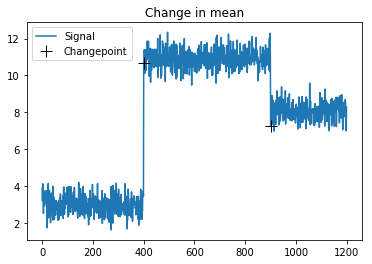

In [3]:
my_std = 0.5
np.random.seed(0)

signal = np.random.normal(3, my_std, my_changepoints[0])
signal = np.append(signal,np.random.normal(11, my_std, my_changepoints[1]-my_changepoints[0] ))
signal = np.append(signal,np.random.normal(8, my_std, signal_length-my_changepoints[1] ))
_, ax1 = plt.subplots()
ax1.set_title('Change in mean')
ax1.plot(signal, label='Signal')
ax1.plot(my_changepoints,signal[my_changepoints], 'k+',  markersize=12,label='Changepoint')
ax1.legend()
# plt.savefig('CP-change_in_mean.png') # uncomment to save a local copy
plt.show()

### Change in variance

A *change in variance* can be interpreted as noise in your signal:

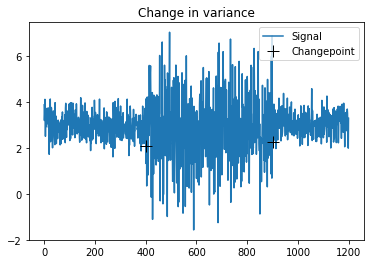

In [4]:
my_mean = 3
np.random.seed(0)

signal = np.random.normal(my_mean, my_std, my_changepoints[0])
signal = np.append(signal,np.random.normal(my_mean, 3*my_std, my_changepoints[1]-my_changepoints[0] ))
signal = np.append(signal,np.random.normal(my_mean, my_std, signal_length-my_changepoints[1] ))
_, ax1 = plt.subplots()
ax1.set_title('Change in variance')
ax1.plot(signal, label='Signal')
ax1.plot(my_changepoints,signal[my_changepoints], 'k+', markersize=12,label='Changepoint')
ax1.legend(loc='upper right');

### Change in periodicy

A *change in periodicy* is sometimes also called *change in frequency*:

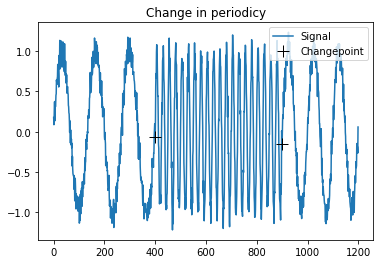

In [5]:
np.random.seed(0)
# first sequence
tmp = np.linspace(0, 20*np.pi, my_changepoints[0])
signal = np.sin(0.3*tmp)
# second sequence
tmp = np.linspace(0, 20*np.pi, my_changepoints[1]-my_changepoints[0])
signal = np.append(signal,np.sin(2*tmp))
# 3rd sequence
tmp = np.linspace(0, 20*np.pi,signal_length-my_changepoints[1])
signal = np.append(signal,np.sin(0.3*tmp))
# add small white noise
signal = signal + np.random.normal(0,0.1,len(signal))
_, ax1 = plt.subplots()
ax1.set_title('Change in periodicy')
ax1.plot(signal, label='Signal')
ax1.plot(my_changepoints,signal[my_changepoints], 'k+', markersize=12,label='Changepoint')
ax1.legend(loc='upper right');

### Change in pattern

Change in pattern is probably the most difficult change to tackle.

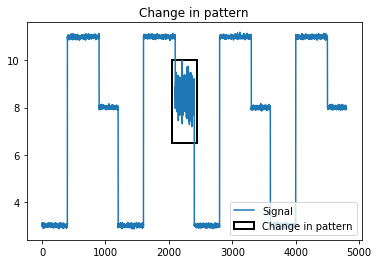

In [6]:
segment_lengths = [400,500,300] # similar to pattern above (change in mean)
np.random.seed(0)
signal = np.array([])
# create the patterns
for p in range(4):
    signal = np.concatenate((signal, np.random.normal(3, 0.05, segment_lengths[0])))
    signal = np.concatenate((signal, np.random.normal(11, 0.05, segment_lengths[1])))
    signal = np.concatenate((signal, np.random.normal(8, 0.05, segment_lengths[2])))
# create the change
signal[2100:2400] = np.random.normal(8, 0.5, segment_lengths[2])+0.5
# plot the signal
from matplotlib.patches import Rectangle
_, ax1 = plt.subplots()
ax1.set_title('Change in pattern')
currentAxis = plt.gca()
currentAxis.add_patch( Rectangle((2050, 6.5), 400, 3.5, color = 'k', fill=None, linewidth=2) )
ax1.plot(signal)
ax1.legend(['Signal','Change in pattern'],loc='lower right');

## 2) Some theory as background of changepoint analysis

To get a more formal idea of a changepoint we summarize the ideas of (Truong et al. 2018b) in this section.

### How to define a changepoint

If we consider the signal as *segments* of random variables there is a suitable way to describe changepoints. To put it simply, a changepoint means that the random variables have the same distribution in the first sequence, but the distribution changes abrupty at the changepoint. 

Let's recall the example at the beginning (change in mean, see above) where we had 3 segments of normal distributed random variables, namely:
- $y_1,\cdots,y_{400} \sim N(3,0.5)$,
- $y_{401},\cdots,y_{900} \sim N(11,0.5)$, and
- $y_{901},\cdots,y_{1200} \sim N(8,0.5)$.

Now, let' write down the definition in a way such that it can be applied in a more general setup. Basically, we may not have *normal distributed* random variables in the signal. In fact, it could be *any distribution* that changes to another distribution. Note, that our definition is a little bit simplified, a more generic definition of a changepoint can be found in (Truong et al. 2018b).

**Definition:**

Let $T>1$ denote the signal length. Let $1 < t^{\ast} <  T$, i.e. $t^{\ast}$ divides the signal in two parts. 

If the distribution is the same for the segment $y_1,\cdots,y_{t^{\ast}}$ and the distribution changes **abrupty** at $t^{\ast}+1$ (and the new distribution stays the same after the change), then $t^{\ast}+1$ is called a *changepoint*.

**Example**


Let's generate and plot another example. How many changepoints do we have? One or two? 

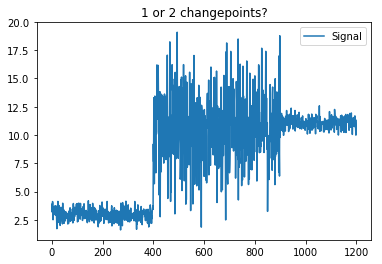

In [7]:
np.random.seed(0)

signal = np.random.normal(3, my_std, my_changepoints[0])
signal = np.append(signal,np.random.normal(11, 3, my_changepoints[1]-my_changepoints[0] ))
signal = np.append(signal,np.random.normal(11, my_std, signal_length-my_changepoints[1] ))
_, ax1 = plt.subplots()
ax1.set_title('1 or 2 changepoints?')
ax1.plot(signal, label='Signal')
ax1.legend(loc='upper right');

By the definition above we have two changepoints, namely $400$ and $900$ because the *distribution* changes abruptly. 

However, after the first changepoint the *mean* of the signal does not change any more. That means we have only one *change in mean* (the 2nd and the 3rd sequence have the same mean value but different variances). However, many applications focus on change in mean and many methods are developed for changes in mean only.

**For the rest of this blog we will consider changes in mean only.** 

### Cost functions

Let's consider the following signal consisting of $T=20$ datapoints with $t^\ast = 10$. Here, we have a change in mean, i.e. the signal is constant (with some noise) before the changepoint $t^\ast = 10$ and the mean changes abruptly.

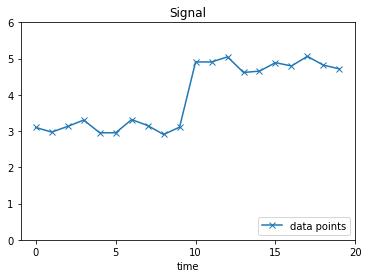

In [8]:
# fix seed => same signal for the rest of the blog
np.random.seed(42) 
# create the signal
my_changepoint=10
signal_length = 20
data = np.random.normal(3, 0.2, my_changepoint)
data = np.append(data,np.random.normal(5,0.2,10))
# plot the signal
_,ax1 = plt.subplots()
ax1.plot(data,label = "data points",marker="x")
ax1.set_title('Signal')
ax1.legend(loc='lower right')
ax1.set_ylim(0,6)
plt.xticks([0,5,10,15,20])
plt.xlabel("time");

There exist many approaches to detect a changepoint. One common way is to define a *cost function*. 

The costs should be "low" as long as the signal is constant and raise when a change in the signal occurs. A statistical function that has such a property is the *sample standard deviation*. 

Now, the main idea is that you run through the whole signal and calculate the cost for the 1st point, then for the first 2 points, then for the first 3 points and so on.

In [9]:
signal_length = 20
my_costs = np.zeros(signal_length)
for i in range(1,signal_length):
    my_costs[i] = data[0:i].std()

Let's plot the signal again, this time including the calculated costs:

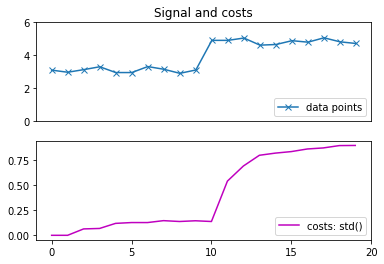

In [10]:
_,ax1 = plt.subplots(nrows=2)
ax1[0].plot(data,label = "data points",marker="x")
ax1[0].set_title('Signal and costs')
ax1[0].legend(loc='lower right')
ax1[0].set_xticks([])
ax1[0].set_ylim(0,6)
plt.xticks([0,5,10,15,20])
ax1[1].plot(my_costs,label = "costs: std()",color='m')
ax1[1].legend(loc='lower right')
plt.xticks([0,5,10,15,20]);

The cost raises at time $t=10$ as we would expect. The animations below shows the whole idea one more time.

In [11]:
%%HTML
<div align="middle">
<video width="50%" controls>
      <source src="./Images/Animation_Cost-Function-L2.mp4" type="video/mp4">
</video></div>

## 3) Example of detecting change in mean

Changes in mean is the most established case in changepoint detection in literature. It is not a surprise that there are standard implementations of standard methods available. Hence, we can use a software package to find the changepoints automatically. 

Of course, there are several packages that can be used for changepoint detection. A well established package in literature is the python *ruptures* package (Truong et al. 2018a), a full documentation can be found at https://ctruong.perso.math.cnrs.fr/ruptures-docs/build/html/index.html.

Let's reconsider the example from the very beginning of the blog:

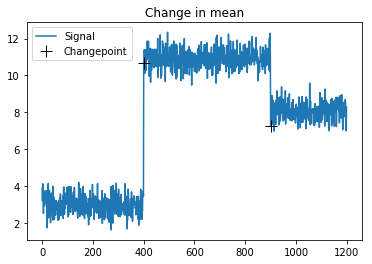

In [12]:
# code is a little bit different from what we have at the beginning
my_changepoints=[400,900]
my_std = 0.5
np.random.seed(0)
# 3, 8, 11: mean values
signal = np.random.normal(3, my_std, 400)  # 400: length of sequence
signal = np.append(signal,np.random.normal(11, my_std, 500 )) # 500= 900-400
signal = np.append(signal,np.random.normal(8, my_std, 300 ))  # 300=1200-900
# # uncomment to add another sequence
# signal = np.append(signal,np.random.normal(5, my_std, 200 ))
# my_changepoints=[400,900,1200]
_, ax1 = plt.subplots()
ax1.set_title('Change in mean')
ax1.plot(signal, label='Signal')
ax1.plot(my_changepoints,signal[my_changepoints], 'k+', markersize=12,label='Changepoint')
ax1.legend();

### Apply the ruptures package

The main idea of the ruptures package is to divide ("to rupture") the signal in segments where the costs of the segments - e.g. the sample standard deviations - are minimized. One way to do this is calculate the costs for each possible segmentation. But that might become a long calculation. 

To avoid long calculation times we will use the approach of the **binary segmentation method** which is a well known algorithm to detect changes in mean. 

This method starts by dividing the signal in two segments and takes the two segments which have the minimal cost. So, we get the first changepoint that is now fixed. After that it subdivides one of the two remaining segments with the second changepoint, obtaining three segments and so on.

Anyway, here a brief summary of the calculation we are doing:

- We take the *binary segmentation method* to detect the two changepoints. 
- We take the *least squared deviation* (denoted by "l2") as cost function. It is a small simplification of the standard deviation.
- We know that we have two breakpoints, therefore we provide the information *n_bkps=2*.

This can be done in two number of lines of code:

In [13]:
# define the search method: binary segmentation; select cost function "l2"
algo = rpt.Binseg(model="l2").fit(signal)
# the actual calculation of the changepoint
my_bkps = algo.predict(n_bkps=2)
# print the result
print('Detected changepoints:')
print(my_bkps)

Detected changepoints:
[400, 900, 1200]


It seems like we detected the changepoints as defined above. That's good news.

Let's see how the detected changepoints look like:

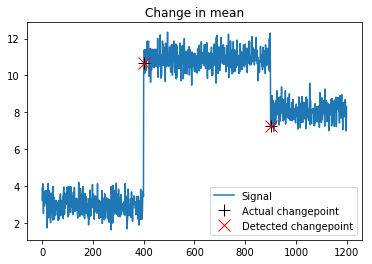

In [14]:
my_bkps = my_bkps[0:-1] # remove the last changepoint (last point of the signal is always marked as changepoint)
_, ax1 = plt.subplots()
ax1.set_title('Change in mean')
ax1.plot(signal, label='Signal')
ax1.plot(my_changepoints,signal[my_changepoints], 'k+', markersize=12,label='Actual changepoint')
ax1.plot(my_bkps,signal[my_bkps], 'rx', markersize=12,label='Detected changepoint')
ax1.legend();

## 4) Discussion

We have found a quite simple code to calculate changepoints using the *binary segmentation method*. It seems, like the runtime is very fast and it found the actual changepoints. 

However, we still have some drawbacks. For example, we provided the information to the algorithm that we have exactly two changepoints. It is not clear if the method will work even if we don't supply this information. Furthermore, the signals we generated are quite artificial and they might be a little bit unrealistic for practical application. Moreover, it can be shown (as a theoretical result) that the binary segmentation does not necessarily yield the optimal changepoints (Killick et al. 2012). Finally, we have not tried if the method works for other changes as change in mean.

### Summary

Let's summarize the advantages and disadvantages of the method we have so far, namely the *binary segmentation method*:

**Pros:**

- established standard method, easy in coding
- short runtime
- yields exact changepoints (change in mean) if number of changepoints provided.

**Cons:**

- does not necessarily yield the optimized number of changepoints 
- may not work for more realistic signals
- works for change in mean only.

## 5) Literature

- Aminikhanghahi, Samaneh; Cook, Diane J. (2017): A Survey of Methods for Time Series Change Point Detection. In Knowledge and information systems 51 (2), pp. 339–367. DOI: 10.1007/s10115-016-0987-z.
- Killick, R.; Fearnhead, P.; Eckley, I. A. (2012): Optimal Detection of Changepoints With a Linear Computational Cost. In Journal of the American Statistical Association 107 (500), pp. 1590–1598. DOI: 10.1080/01621459.2012.737745.
- Truong, Charles; Oudre, Laurent; Vayatis, Nicolas (2018a): ruptures: change point detection in Python. Available online at http://arxiv.org/pdf/1801.00826v1.
- Truong, Charles; Oudre, Laurent; Vayatis, Nicolas (2018b): Selective review of offline change point detection methods.